## Mini Project -- Machine Learning for Public Policy ##

# Student ID -- 12410247 #

In [23]:
# set-up steps
import pandas as pd
import numpy as np
import math
import warnings
from pandas.errors import SettingWithCopyWarning 

warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
proj_df = pd.read_csv("usa_00001.csv")
cross_df = pd.read_csv("PPHA_30545_MP01-Crosswalk.csv")

## 3 - Preparing the Data

In [24]:
# 2(a) -- education variable re-coding -- used ChatGPT to convert the .cbk into a useful dictionary format
edu_map = {
    '000': 'N/A or no schooling',
    '001': 'N/A',
    '002': 'No schooling completed',
    '010': 'Nursery school to grade 4',
    '011': 'Nursery school, preschool',
    '012': 'Kindergarten',
    '013': 'Grade 1, 2, 3, or 4',
    '014': 'Grade 1',
    '015': 'Grade 2',
    '016': 'Grade 3',
    '017': 'Grade 4',
    '020': 'Grade 5, 6, 7, or 8',
    '021': 'Grade 5 or 6',
    '022': 'Grade 5',
    '023': 'Grade 6',
    '024': 'Grade 7 or 8',
    '025': 'Grade 7',
    '026': 'Grade 8',
    '030': 'Grade 9',
    '040': 'Grade 10',
    '050': 'Grade 11',
    '060': 'Grade 12',
    '061': '12th grade, no diploma',
    '062': 'High school graduate or GED',
    '063': 'Regular high school diploma',
    '064': 'GED or alternative credential',
    '065': 'Some college, but less than 1 year',
    '070': '1 year of college',
    '071': '1 or more years of college credit, no degree',
    '080': '2 years of college',
    '081': "Associate's degree, type not specified",
    '082': "Associate's degree, occupational program",
    '083': "Associate's degree, academic program",
    '090': '3 years of college',
    '100': '4 years of college',
    '101': "Bachelor's degree",
    '110': '5+ years of college',
    '111': '6 years of college (6+ in 1960-1970)',
    '112': '7 years of college',
    '113': '8+ years of college',
    '114': "Master's degree",
    '115': "Professional degree beyond a bachelor's degree",
    '116': "Doctoral degree",
    '999': 'Missing'
}
# need to add zeroes to match the coding format
def add_zeroes(cell):
    cell = str(cell)
    if len(cell) == 1:
        return cell.zfill(3)
    elif len(cell) == 2:
        return cell.zfill(3)
    else:
        return cell

proj_df['EDUCD'] = proj_df['EDUCD'].apply(add_zeroes)
cross_df['educd'] = cross_df['educd'].apply(add_zeroes)
proj_df['educd_attain'] = proj_df['EDUCD'].astype(str).map(edu_map)


# using the crosswalk to re-code the education data as a continuous variable
educ_dict = dict(zip(cross_df['educd'], cross_df['educdc']))
proj_df['educd'] = proj_df['EDUCD']
proj_df['educdc'] = proj_df['educd'].map(educ_dict)
ipums_df = proj_df.copy()
ipums_df['educdc'] = pd.to_numeric(ipums_df['educdc'], errors= 'coerce') 

# 2(b) -- dummy variables
# i - hsdip -- assuming all education below completing college is a high school diploma
ipums_df['hsdip'] = np.where((ipums_df['EDUCD'].isin(['062','063','064','065','070','071','080','090','100'])), 1,0)
# ii - coldip -- assuming years of college beyond 4 can also be counted as a bachelors degree
ipums_df['coldip'] = np.where((ipums_df['EDUCD'].isin(['101','110','111','112','113','114','115','116'])), 1,0)
# iii - white
ipums_df['white'] = np.where((ipums_df['RACE'] == 1), 1, 0)
# iv - black
ipums_df['black'] = np.where((ipums_df['RACE'] == 2), 1, 0)
# v - Hispanic -- assuming that if we ignore missing and non-hispanic, we by definition have hispanic
ipums_df['hispanic'] = np.where((~ipums_df['HISPAN'].astype(str).isin(['0','9'])), 1, 0)
# vi - married
ipums_df['married'] = np.where((ipums_df['MARST'].astype(str).isin(['1','2'])), 1,0)

# vii - female
ipums_df['female'] = np.where((ipums_df['SEX'] == '2'), 1,0)
# viii - veteran -- assuming that flagging the different types of veterans will show reserve duty
ipums_df['vet'] = np.where((ipums_df['VETSTATD'].astype(str).isin(['20','21','22','23'])), 1,0)

# 2(c) -- interaction terms #
ipums_df['hsdip_x_educdc'] = ipums_df['hsdip'] * ipums_df['educdc']
ipums_df['coldip_x_educdc'] = ipums_df['coldip'] * ipums_df['educdc'] 


# 2(d) -- creating new variables #
ipums_df['age_squared'] = ipums_df['AGE'] ** 2 
ipums_df['ln_incwage'] = np.where(ipums_df['INCWAGE'] > 0, np.log(ipums_df['INCWAGE']), np.nan) 

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 4 - Data Analysis Questions

In [25]:
# 1 - summary statistics

target_vari_column_names = ['YEAR', 'INCWAGE', 'ln_incwage', 'educdc', 'female', 'AGE', 'age_squared', 'white', 'black', 'hispanic', 'married', 'NCHILD', 'vet', 'hsdip', 'coldip', 'hsdip_x_educdc','coldip_x_educdc']
summary_stats = ipums_df[target_vari_column_names].describe()
print(summary_stats.head(3))

         YEAR       INCWAGE   ln_incwage       educdc  female          AGE  \
count  9127.0   9127.000000  8663.000000  9127.000000  9127.0  9127.000000   
mean   2023.0  65746.696614    10.672053    14.272926     0.0    41.948176   
std       0.0  79521.247933     1.095996     3.062236     0.0    13.364299   

       age_squared        white        black     hispanic      married  \
count  9127.000000  9127.000000  9127.000000  9127.000000  9127.000000   
mean   1938.234360     0.662321     0.083489     0.160294     0.546839   
std    1128.253604     0.472945     0.276634     0.366898     0.497829   

            NCHILD          vet        hsdip       coldip  hsdip_x_educdc  \
count  9127.000000  9127.000000  9127.000000  9127.000000     9127.000000   
mean      0.800701     0.041744     0.433439     0.408239        5.533910   
std       1.118963     0.200015     0.495577     0.491535        6.354072   

       coldip_x_educdc  
count      9127.000000  
mean          6.932179  
std   

/var/folders/6y/z0315m514rx79r25lwyjx_d80000gn/T/ipykernel_1784/2488273959.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ipums_df['ln_incwage'].fillna(mean_ln_incwage, inplace=True)


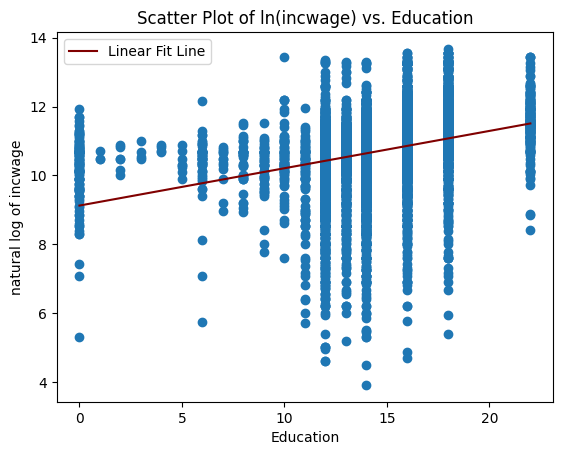

In [26]:
# 2 - Scatterplotting
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# first version failed, missing values for ln_incwage mean that we need to adjust the data
# I am going to use the mean instead of fully removing rows from the dataset
mean_ln_incwage = ipums_df['ln_incwage'].mean()
ipums_df['ln_incwage'].fillna(mean_ln_incwage, inplace=True)

# linear regression calculation
slope, intercept, r_value, p_value, std_err = stats.linregress(ipums_df['educdc'], ipums_df['ln_incwage'])
x_var = np.linspace(ipums_df['educdc'].min(), ipums_df['educdc'].max(), 100)
y = slope * x_var + intercept

# plotting steps
plt.scatter(ipums_df['educdc'], ipums_df['ln_incwage'])
plt.xlabel('Education')
plt.ylabel('natural log of incwage')
plt.title('Scatter Plot of ln(incwage) vs. Education')
plt.plot(x_var, y, color= 'maroon', label= 'Linear Fit Line')
plt.legend()


plt.show()

In [27]:
# 3 -- building a new regression model
import statsmodels.formula.api as smf

lin_formula = 'ln_incwage ~ educdc + female + AGE + age_squared + white + black + hispanic + married + NCHILD + vet'
lin_model = smf.ols(lin_formula, data= ipums_df).fit()

print(lin_model.summary())


                            OLS Regression Results                            
Dep. Variable:             ln_incwage   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     365.3
Date:                Thu, 30 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:08:09   Log-Likelihood:                -12144.
No. Observations:                9127   AIC:                         2.431e+04
Df Residuals:                    9117   BIC:                         2.438e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.8539      0.113     51.809      

# Interpretation #

a) Looking at our data summary, it appears that our R-squared = 0.265, meaning that after all of our variables are included, they only account for 26.5% of the variation in ln(wages). This would appear to signal that there are a lot of variables influencing wages that are outside of the dataset! Thinking about this critically, some variables like the location of employment would signal wage potentially better than some of the variables we have already included, since a job in NYC is paying higher than rural Montana typically.

b) The predicted return on an additional year of education, according to the model above, is ~9%. Since we are dealing with the natural log (ln) change in wage as a result of a 1 year increase in the education variable, we must interpret the change in coefficient (0.0880) as a percent, not a direct dollar figure.

c) Curiously, we observe that the age coefficient is (0.1588) but the age_squared coefficient is (-0.0017), meaning that there is a value of age where there is diminishing returns! We can find this point by assuming that there is a parabolic increase (goes up and down smoothly as age increases, we do have reason to suspect that this _may not_ be the true case, espeically on the early end, but we shall ignore that for simplicity), and to find the vertex of a parabola we can use the formula x = -b / (2 * a), or x = -0.1588 / (2 * -0.0017). This gives us an x = 46.705, so let's round it to 47 years of age since that is the format AGE is reported in from the original dataset.

d) All else equal, the model shows a very weakly positive coefficient for the female variable (3.073e-14) meaning that there is technically a higher wage, but the number is so small that it would indicate a predicted difference of a tiny fraction of a cent. It's quite possible that this is not indicative of a true relationship in the general population, this dataset focuses on formal jobs and wages, as one possible issue. Women represent an outsized proportion of underreported wages in sectors such as housekeeping (88% per Statista - https://www.statista.com/statistics/1086892/share-maids-housekeeping-cleaners-united-states-gender) and those roles are historically victim to lower pay than traditional jobs, so the true effect of gender in society on wages could be very different. This is just one way by which we could be concerned that this variable is not accurate. 

e) We can see from our white coefficient value (0.0339) and our black coefficient value (-0.1846) sharply different predicted effects from an individual's race. All else equal, we expect a ~3% _increase_ in expected wage given white and a ~18% __decrease__ in salary given black. Per the 2020 Census, 75% of Americans identified as white, so the fact that this is such a large share of the population we would expect them to roughly reflect the average wage and it is predictable that there would be a relatively small coefficient value (noting that the 75% figure is Hispanic inclusive, white alone is still 58% and the point still stands). However, the fact that Black Americans have this magnitude of decrease in expected wages shows a systemic lack of opportunity to earn greater wages, given that in our all-else-equal scenario, education, age, and the other factors that influence wages would be held equal!  

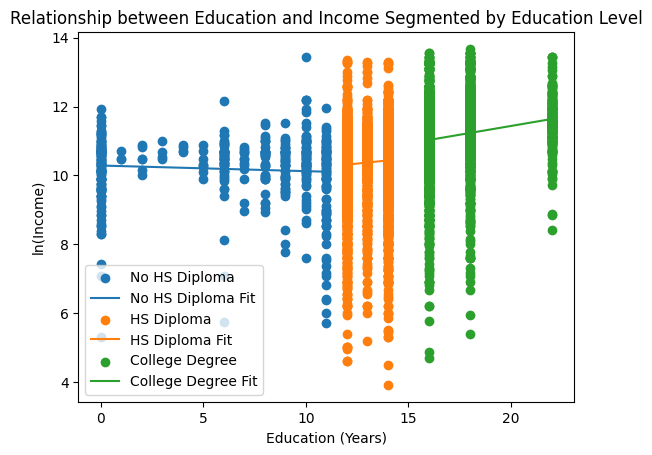

In [28]:
# 4 -- graphing wages vs. education based on levels
# setting data bins
bins = [12, 16, np.inf]
labels = ['No HS Diploma', 'HS Diploma', 'College Degree']

# 2. assigning labels based on bins
indices = np.digitize(ipums_df['educdc'], bins, right= False)
ipums_df['edu_level'] = pd.Series([labels[i] if i < len(labels) else None for i in indices])

# 3. Plotting and linear regressing:
for level in labels: 
    level_df = ipums_df[ipums_df['edu_level'] == level]

    if not level_df.empty:
        x = level_df['educdc'].values
        y = level_df['ln_incwage'].values

        slope, intercept = np.polyfit(x, y, 1)
        x_plot = np.linspace(x.min(), x.max(), 100)
        y_plot = slope * x_plot + intercept

        plt.scatter(x, y, label= level)
        plt.plot(x_plot, y_plot, label= f'{level} Fit')
        
# labels and titles
plt.xlabel('Education (Years)')
plt.ylabel('ln(Wages)')
plt.title('Relationship between Education and Income Segmented by Education Level')
plt.legend()


# 5(a) -- reasoning for our differential intercept approach

- Our Differential intercept and slope model of log wages would take the form of:
    ln{wages} = (intercept) + B1*(education level) + B2*(female) + B3*(age) + B4*(age^2) + B5(white) + B6*(black) + B7*(hispanic) + B8*(married) + B9*(number of children) + B10*(veteran status) 
Where the values in the parentheses represent the x variables, the Bn values represent the regression coefficients, and ln{wages} is the target result of the regression

- In my estimation, this model is a very poor representation of the way the world works. There are several notable factors not present in the model, such as the sector of employment or the location of the job as mentioned earlier that would have a far greater influence over the likely wage. Logically, we know that simply because one is a veteran does not mean that a workplace will give them a higher salary, all else equal, so we can already start to see some of the cracks in the logic of this regression. That being said, we are fairly confident given the R^2 score that we are not overfitting here, the error term has plenty of leeway in this regression. These variables we have included are broadly applicable to the entire population, bending our proverbiale canvas around these 'tent poles' does not displace the fabric of the regression unrealistically.

Differential Intercept Model:
                            OLS Regression Results                            
Dep. Variable:             ln_incwage   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     354.2
Date:                Thu, 30 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:08:09   Log-Likelihood:                -12051.
No. Observations:                9127   AIC:                         2.412e+04
Df Residuals:                    9116   BIC:                         2.420e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

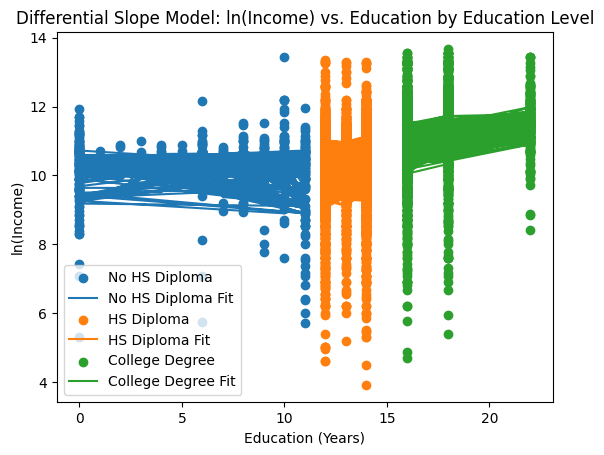

In [29]:
# 5 (b) -- differntial slope, wages

# new model and new slope

new_model_intercept = smf.ols('ln_incwage ~ edu_level + female + AGE + age_squared + white + black + hispanic + married + NCHILD + vet', data= ipums_df).fit()
print("Differential Intercept Model:")
print(new_model_intercept.summary())

new_model_slope = smf.ols('ln_incwage ~ educdc*edu_level + female + AGE + age_squared + white + black + hispanic + married + NCHILD + vet', data= ipums_df).fit()
print("\nDifferential Slope Model:")
print(new_model_slope.summary())

# plotting since just estimating the model is not enough to grasp the concepts well
for level in ['No HS Diploma', 'HS Diploma', 'College Degree']:
    level_df = ipums_df[ipums_df['edu_level'] == level]

    if not level_df.empty: 
        x = level_df['educdc'].values
        y = level_df['ln_incwage'].values

        predictions = new_model_slope.predict(level_df)

        plt.scatter(x, y, label= level)
        plt.plot(x, predictions, label= f'{level} Fit')

plt.xlabel('Education (Years)')
plt.ylabel('ln(Income)')
plt.title('Differential Slope Model: ln(Income) vs. Education by Education Level')
plt.legend()
plt.show()

# 5(c) -- wage prediction #

predicted earnings for hs = 7.6752 + (0.1475)*(22) + (-0.0015)*(22) + [female coefficient is approximately 0] + _(-0.5861)_*(1) = 8.4002 

predicted earnings for college = 7.6752 + (0.1475)*(22) + (-0.0015)*(22) + [female coefficient is approximately 0] + __(0.0709)__*(1) = 10.9581

conversion from ln(wage) to estimated wage acheived by raising resultin values into the exponent of (e)

# 5(d) -- wage prediction - explained #

The results in part 5(c) are the log wage values , and converting them to real dollars equals an estimated salary of __$57,417.25__ for a college grad and __$44,479.56__ for a high school grad under the conditions presented. These values came from my regression analysis in part (b), which intentionally used those same educational year breaks. This would indicate a predicted higher wage (by __$12,937.76__)for such an individual if they were to attend college!

# 5(e) -- college subsidies recommended? - explained #

Based off of the results of our regression, there is a reasonable statistical case that these results are significant, and therefore should be considered. It is somewhat concerning that the t-scores for our non-HS Diploma coefficient are so poor as to be statistically insignificant, however the results for HS Diploma and College Diploma are strong (at the alpha = 0.05 level) are statstically significant. The value of the expected added wages (calculated in 5(d)) is certainly large enough in magnitude that it would be worth investing for the government, keeping in mind that this is just in the first year out of college. Intuitively, we expect this gap of $12k to only grow as these two different versions of the same person age and accumulate professional experience.

# 5(f) -- r squared evaluation, compare to 3 #

Per the R^2 results of our model in part (b), we observe a value of 0.280, or put in simpler terms, the included variables in this regression account for just 28% of the variation observed in our data set. Looking at the model from part 3, where we saw an R^2 value of 0.265, this model represents a modest improvement. These values do indicate however that there is still a great deal of variation in the resulting natural log wages values that are not accounted for by the model(s) as presently constructed and we may need to consider including additional factors.

# 5(g) -- explain p-value significance #

Our confidence in this regression analysis is mixed. On the one hand, the sample size is large enough where we can see some strong, and perhaps more importantly, statistically significant trends. However, we are also seeing R^2 values that would indicate we have factors not included in our model that would explain a lot more of the variation. My recommendation to the President here would be that she re-survey within each state and allow for us to contextualize the salary findings with the rural-urban socio-economic divide, which, among other dimmensions of potential missing factors in our model, may be the easiest to overcome!

In [34]:
# 6(a) - First Pass Splines 
import sklearn
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

X_age = ipums_df[["AGE"]]
y = ipums_df["ln_incwage"]

# spline construction
knots = np.array([18, 65]).reshape(-1, 1)
spline_transformer = SplineTransformer(degree= 3, knots= knots, include_bias=False)
X_splines = spline_transformer.fit_transform(X_age)
X = np.hstack([X_splines])


# aligning a model to our spline
model = LinearRegression()
model.fit(X, y)

# Feature names for formula (from transformed data)
feature_names = [f"spline_{i}" for i in range(X_splines.shape[1])]

# Create the formula (using feature names)
formula = 'ln_incwage ~ ' + ' + '.join(feature_names)

# Create a statsmodels linear regression model
model_sm = smf.ols(formula, data=pd.concat([pd.DataFrame(X_splines, columns=feature_names), pd.DataFrame(y, columns=['ln_incwage'])], axis=1)).fit()

# Print the summary
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_incwage   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     755.3
Date:                Thu, 30 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:41:49   Log-Likelihood:                -12536.
No. Observations:                9127   AIC:                         2.508e+04
Df Residuals:                    9123   BIC:                         2.511e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.1568      0.895     18.048      0.0

# 6(a) - Cubic Splines #
The Adjusted R^2 value for part a is 0.199

# 6(b) - Interpreting our Cubic Splines #
As noted above, the adjusted R^2 value was found to be 0.199, which is in fact lower than what we found in our regression from Question 3 (0.265). This means that our new spline-based modeling captures less of the variance in our data, which could perhaps indicate that the spline creation process is not calibrated well, a possible cause of this is that our added degrees of freedom is leading to overfitting.

In [36]:
# 6(c) -- Targeted Splines

# 24 & 55 version (c_ version)

X_age = ipums_df[["AGE"]]
y = ipums_df["ln_incwage"]

# spline construction
c_knots = np.array([24, 55]).reshape(-1, 1)
c_spline_transformer = SplineTransformer(degree= 3, knots= c_knots, include_bias=False)
c_X_splines = c_spline_transformer.fit_transform(X_age)
c_X = np.hstack([c_X_splines])

c_model = LinearRegression()
c_model.fit(c_X, y)

# Feature names for formula building
c_feature_names = [f"spline_{i}" for i in range(c_X_splines.shape[1])]
c_formula = 'ln_incwage ~ ' + ' + '.join(c_feature_names)

# Create a statsmodels linear regression model
c_model_sm = smf.ols(c_formula, data= pd.concat([pd.DataFrame(c_X_splines, columns= c_feature_names), pd.DataFrame(y, columns=['ln_incwage'])], axis=1)).fit()

# Print the summary
print(c_model_sm.summary())


# 18 & 47 version (a_ version) - value derived from the age_squared peak found in 3(c)
X_age = ipums_df[["AGE"]]
y = ipums_df["ln_incwage"]

# spline construction
a_knots = np.array([18, 47]).reshape(-1, 1)
a_spline_transformer = SplineTransformer(degree= 3, knots= a_knots, include_bias=False)
a_X_splines = a_spline_transformer.fit_transform(X_age)
a_X = np.hstack([a_X_splines])

a_model = LinearRegression()
a_model.fit(a_X, y)

# Feature names for formula building
a_feature_names = [f"spline_{i}" for i in range(a_X_splines.shape[1])]
a_formula = 'ln_incwage ~ ' + ' + '.join(a_feature_names)

# Create a statsmodels linear regression model
a_model_sm = smf.ols(a_formula, data= pd.concat([pd.DataFrame(a_X_splines, columns= a_feature_names), pd.DataFrame(y, columns=['ln_incwage'])], axis=1)).fit()

# Print the summary
print(a_model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_incwage   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     593.4
Date:                Thu, 30 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:54:00   Log-Likelihood:                -12735.
No. Observations:                9127   AIC:                         2.548e+04
Df Residuals:                    9123   BIC:                         2.551e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.3686      0.685     19.502      0.0

# 6(c) -- explaining our two splines

- First spline resulted in an adjusted r^2 value of 0.163, the second spline resulted in an adjusted r^2 value of 0.203!

Based off of the adjusted r^2 values alone, I would lean towards the second spline that I came up with. The values I selected were 18 (the age when many people enter the workforce) and 47, the value we found back in question 3(c) that indicated the peak of wage increase with respect to age/age^2, I wanted to test and see if that value would also make for a good spline location!

In [47]:
# 6(d) -- test cases with our 24 & 55 spline #

# Pulling down coefficients and setting targets
coefficients = c_model_sm.params

# Print coefficients 
print(coefficients) 

# Ages for prediction
ages = [17, 50]

# Predict ln(wage) for each age (assuming 'female' is 1)
predicted_wages = []
for age in ages:
    predicted_ln_wage = coefficients['Intercept'] + coefficients['spline_0']*age + coefficients['spline_1']*age**2 + coefficients['spline_2']*age**3
    predicted_ln_wages.append(predicted_ln_wage)

print("Predicted wage for ages:", ages)
print(predicted_ln_wages) 

Intercept    13.368554
spline_0    -15.636388
spline_1     -0.714972
spline_2     -3.558215
dtype: float64
Predicted wage for ages: [17, 50]
[-17940.58666702769, -447332.7414470563, -17940.58666702769, -447332.7414470563]


# 6(d) -- test cases with our 24 & 55 spline explained #

The results here are surprisingly negative, I can only assume that splines are either not meant to be applied in this fashion or somewhere in my code this did not extract properly and a sign flip occured. I am assuming the later, since the differing values actually look pretty good. A salary of $17,940.57 for the 17 year old sounds fair considering this is a part-time, minimum wage level of salary that would be typical for someone at that age.